In [1]:
import sys, os, time, shutil
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
# %load_ext autoreload
# %autoreload 2
# %pdb
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

import gym
import inspect
import numpy as np
import pickle

#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn
#from foundation.util import replicate, Cloner

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')

# import gpumap
# import umap, shap
# import umap.plot

from sklearn.decomposition import PCA
import sklearn.datasets

# import gpumap

%matplotlib notebook

# import project as proj
# import pointnets as ptn

np.set_printoptions(linewidth=120)

In [2]:
from c3linearize import linearize, class_graph

In [10]:
from collections import defaultdict

In [3]:
class T(object):
    pass

In [6]:
type(T) == type

True

In [11]:
root = 'c:/Users/anwan/Documents/workspace/local_data/3dshapes'

In [12]:
os.listdir(root)

['3dshapes_stats_fid.pkl',
 '3dshapes_stats_fid_test.pkl',
 '3dshapes_stats_fid_train.pkl',
 '3dshapes_test.h5',
 '3dshapes_train.h5']

In [14]:
p = pickle.load(open(os.path.join(root, '3dshapes_stats_fid.pkl'), 'rb'))

In [18]:
p.keys()

dict_keys(['indices', 'm', 'sigma'])

In [3]:
model = fd.eval.fid.load_inception_model(dim=2048, device='cuda:1')
model

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to C:\Users\anwan/.cache\torch\checkpoints\pt_inception-2015-12-05-6726825d.pth
100%|█████████████████████████████████████████████████| 91.2M/91.2M [00:20<00:00, 4.64MB/s]


InceptionV3(
  (blocks): ModuleList(
    (0): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      

In [8]:
B, D, S = 10, 12, 16
C, H, W = 3, 8, 8
G, K, M = 1, 6, 32

In [9]:
w = torch.empty(D,D)
torch.nn.init.kaiming_normal_(w)
pass

<IPython.core.display.Javascript object>


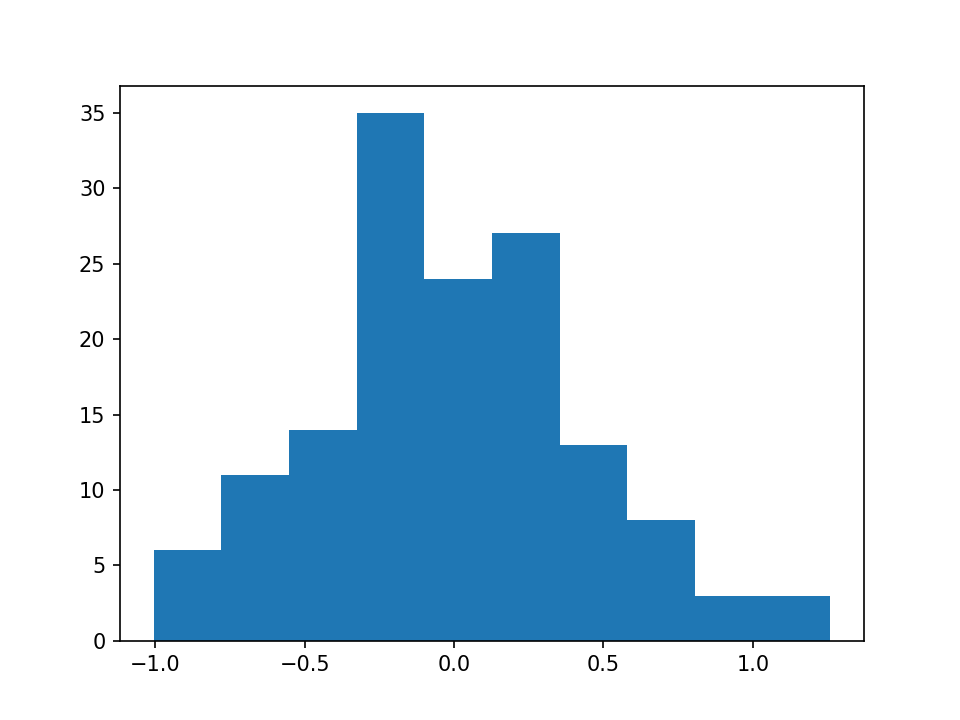

(array([ 6., 11., 14., 35., 24., 27., 13.,  8.,  3.,  3.]),
 array([-1.0047283 , -0.7783692 , -0.55201006, -0.3256509 , -0.09929176,  0.12706739,  0.35342652,  0.57978565,
         0.80614483,  1.032504  ,  1.2588631 ], dtype=float32),
 <a list of 10 Patch objects>)

In [10]:
plt.figure()
plt.hist(w.view(-1).numpy())

In [166]:
class InvDense(fd.Invertible, fd.Model):
    def __init__(self, dim, bias=True, w=None, b=None):
        super().__init__(dim, dim)
        
        if w is None:
            i = 0
            while w is None:
                w = torch.empty(dim, dim)
                nn.init.kaiming_normal_(w)
                if i < 20 and torch.det(w) < 0.1:
                    w = None
                    i += 1
        
        lu, p = torch.lu(w)
        print(p)
        
        self.pivots = p
        self.lu = nn.Parameter(lu, requires_grad=True)
    
        if bias:
            if b is None:
                b = torch.randn(1, dim) / np.sqrt(dim)
            self.b = nn.Parameter(b.view(1, dim), requires_grad=True)
        else:
            self.b = None
    
    def extra_repr(self):
        return 'dim={}, bias={}'.format(self.lu.shape[0], self.b is not None)
    
    def forward(self, x):
        p, l, u = torch.lu_unpack(self.lu, self.pivots)
        y = x @ u.t() @ l.t() @ p.t()
#         y = x @ torch.triu(u).t() @ torch.tril(l).t() @ p.t()
        if self.b is not None:
            y = y + self.b
        return y
    
    def inverse(self, y): # ! can't backprop through inverse !
        if self.b is not None:
            y = y - b
        return torch.lu_solve(y.t(), self.lu.data, self.pivots).t()

In [167]:
x = torch.randn(B,D)
w = torch.empty(D,D)
nn.init.kaiming_normal_(w)
b = torch.randn(1, D)
pass

In [168]:
layer = InvDense(D, w=w, b=b, bias=True)
layer

tensor([8, 5, 6, 5, 6, 8, 7, 8], dtype=torch.int32)


InvDense(dim=8, bias=True)

In [169]:
out = layer(x)
y = x @ w.t() + b
out.shape, y.shape

(torch.Size([128, 8]), torch.Size([128, 8]))

In [170]:
torch.stack([out, y], dim=1)

tensor([[[ 2.4935, -1.9586,  0.7936,  ...,  1.0336,  1.5152, -1.7406],
         [ 2.4935, -1.9586,  0.7936,  ...,  1.0336,  1.5152, -1.7406]],

        [[ 3.1825, -0.7223,  1.2313,  ...,  1.6592,  0.6141, -2.6652],
         [ 3.1825, -0.7223,  1.2313,  ...,  1.6592,  0.6141, -2.6652]],

        [[-1.9942,  0.2054,  1.4162,  ...,  0.6723, -0.7112, -1.6134],
         [-1.9942,  0.2054,  1.4162,  ...,  0.6723, -0.7112, -1.6134]],

        ...,

        [[ 0.9491, -1.0507,  2.2159,  ...,  1.0525, -1.4546,  1.4061],
         [ 0.9491, -1.0507,  2.2159,  ...,  1.0525, -1.4546,  1.4061]],

        [[ 0.1673, -0.9416,  1.9137,  ...,  0.9972, -1.2497, -2.3593],
         [ 0.1673, -0.9416,  1.9137,  ...,  0.9972, -1.2497, -2.3593]],

        [[-0.4341, -0.5419,  0.6284,  ...,  2.4143,  1.5630, -2.3134],
         [-0.4341, -0.5419,  0.6284,  ...,  2.4143,  1.5630, -2.3134]]],
       grad_fn=<StackBackward>)

In [171]:
px = layer.inverse(y)
torch.stack([px, x], dim=1)

tensor([[[ 0.1270, -0.0876, -0.8695,  ...,  1.0812,  1.5532, -1.7208],
         [ 0.1270, -0.0876, -0.8695,  ...,  1.0810,  1.5533, -1.7206]],

        [[ 0.3963,  0.2314, -0.1605,  ...,  0.5637,  0.7447, -2.3959],
         [ 0.3959,  0.2319, -0.1610,  ...,  0.5608,  0.7468, -2.3937]],

        [[ 1.7972, -0.6878, -0.2402,  ...,  0.5269, -1.4953, -0.5031],
         [ 1.7969, -0.6874, -0.2406,  ...,  0.5246, -1.4936, -0.5014]],

        ...,

        [[-0.1380, -0.4550, -0.9690,  ..., -0.9367, -0.6428, -1.1570],
         [-0.1377, -0.4553, -0.9687,  ..., -0.9349, -0.6441, -1.1583]],

        [[ 1.0228,  0.8181,  0.1839,  ...,  0.8974, -0.6702,  0.1612],
         [ 1.0226,  0.8184,  0.1837,  ...,  0.8962, -0.6694,  0.1621]],

        [[ 1.7700, -0.2736,  1.3171,  ...,  1.0983,  1.0434, -1.8569],
         [ 1.7700, -0.2736,  1.3171,  ...,  1.0982,  1.0434, -1.8569]]])

In [247]:
w = torch.empty(D,D)
nn.init.kaiming_uniform_(w, a=np.sqrt(5))
# nn.init.xavier_normal_(w)
nn.init.kaiming_uniform_(w)
# nn.init.kaiming_normal_(w)
torch.det(w)

tensor(1.7514)

In [241]:
l = nn.Linear(D,M)
l.weight.det()

tensor(5.2403e-05, grad_fn=<DetBackward>)

In [22]:
net[0].in_features

8

In [114]:
din = 8
dout = din
depth, breadth = 100, din
nonlin = None

In [115]:
def initializer(layer, nonlin):
#     nn.init.kaiming_normal_(layer.weight)
    din, dout = layer.in_features, layer.out_features
    
    
    spread = 1#/din
#     spread = np.sqrt(2/din) 
#     spread = 
    
    layer.weight.data.normal_(0,spread)
    return layer

net = models.make_MLP(D,M, hidden_dims=depth*[breadth], nonlin=nonlin, initializer=initializer, bias=False)

x = torch.randn(1000,8)
x.mean(0), x.std(0)

with torch.no_grad():
    y = net(x)
    print(y.mean(0))
    print(y.std(0))
#     print(y.mean(-1), y.std(-1))
y

tensor([nan, nan, nan, nan, nan, nan, nan, nan])
tensor([nan, nan, nan, nan, nan, nan, nan, nan])


tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])

In [117]:
graph = {0:[1,2], 1:[3,4], 2:[4,6], 3:[7], 4:[5], 5:[], 6:[], 7:[]}
util.toposort(0,lambda x: graph[x], depth_first=False)

[0, 1, 2, 3, 4, 6, 7, 5]

In [174]:
B = 128
N = B * 1024
D, M = 8, 8
lim = -4, 4

-1.5525214621447958e-05

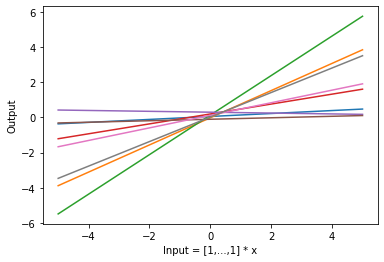

In [199]:
depth, breadth = 3, 64
depth = 0
true = models.make_MLP(D, M, hidden_dims=depth*[breadth], 
                      nonlin='swish', 
                      bias=None, output_bias=True)
util.plot_vec_fn(true)
true[0].weight.det().item()

tensor(-0.0005, grad_fn=<DetBackward>)

In [124]:
mn, mx = lim
with torch.no_grad():
    X = torch.rand(N, D) * (mx-mn) + mn
    Y = true(X)
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=B)
len(dataset), len(loader)

(131072, 1024)

In [125]:
model = InvDense(D)
model

tensor([2, 6, 5, 4, 8, 7, 8, 8], dtype=torch.int32)


InvDense(dim=8, bias=True)

In [126]:
criterion = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=1e-2)
stat = util.AverageMeter(tau=min(100/len(loader), 0.5))

In [127]:
n_epochs = 10

In [128]:
for epoch in range(n_epochs):
    print('starting epoch: {}/{}'.format(epoch+1, n_epochs))
    itr = tqdm(loader)
    for x, y in itr:
        pred = model(x)
        loss = criterion(pred, y)
        stat.update(loss)
        itr.set_description('Loss {:.3f} ({:.3f})'.format(stat.val.item(), stat.smooth.item()))
        optim.zero_grad()
        loss.backward()
        optim.step()

starting epoch: 1/10



starting epoch: 2/10



starting epoch: 3/10



starting epoch: 4/10



starting epoch: 5/10



starting epoch: 6/10



starting epoch: 7/10



starting epoch: 8/10



starting epoch: 9/10



starting epoch: 10/10


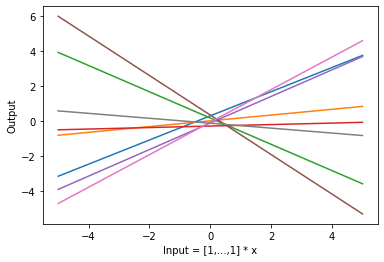

In [131]:
util.plot_vec_fn(model)
pass

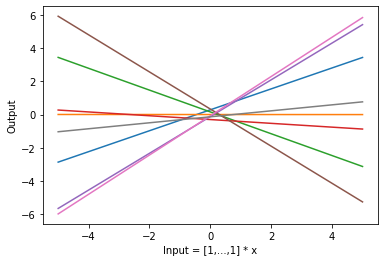

In [132]:
util.plot_vec_fn(true)
pass

In [134]:
model.inverse(y)

tensor([[ -96.5579,  339.7298,  184.7091,  ...,   59.3668,  224.6575,
          -33.9103],
        [ -51.4093,  191.3888,  104.9457,  ...,   31.8842,  120.6896,
          -20.1440],
        [ -62.7195,  214.5622,  124.0801,  ...,   37.1604,  142.9697,
          -23.2467],
        ...,
        [ -15.8171,   56.4393,   35.3900,  ...,   11.7992,   39.0795,
           -3.3670],
        [ -59.2829,  212.4025,  115.0657,  ...,   40.9361,  137.1322,
          -21.6984],
        [-102.0807,  352.7494,  194.1731,  ...,   64.2226,  227.6557,
          -36.0350]])

In [141]:
torch.lu_unpack(model.lu, model.pivots)

(tensor([[0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.]]),
 tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-2.0431,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.4040, -0.9473,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.3365, -0.0041,  1.9065,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.2640,  0.0777, -1.3491, -0.5366,  1.0000,  0.0000,  0.0000,  0.0000],
         [ 1.8013,  0.8476,  0.7589, -0.2574, -1.7653,  1.0000,  0.0000,  0.0000],
         [-1.5527,  1.1153,  0.9246,  1.8914,  0.1215,  1.1557,  1.0000,  0.0000],
         [ 1.5122, -0.4840, -1.2016, -1.0878, -0.5593, -1.1007, -1.4566, 

In [378]:
px = layer.inverse(y)
px.shape

torch.Size([1000, 5])

In [379]:
torch.stack([x,px], dim=1)

tensor([[[ 1.0210,  0.7782, -2.3987, -0.4583, -0.2494],
         [ 1.0210,  0.7782, -2.3987, -0.4583, -0.2494]],

        [[ 1.0029,  0.0392,  1.2159, -0.0564, -0.0807],
         [ 1.0029,  0.0392,  1.2159, -0.0564, -0.0807]],

        [[-0.6100, -0.6243,  1.7635, -0.1961,  1.2692],
         [-0.6100, -0.6243,  1.7635, -0.1961,  1.2692]],

        ...,

        [[-1.0616, -0.1997,  0.8071,  1.1342, -0.3598],
         [-1.0616, -0.1997,  0.8071,  1.1342, -0.3598]],

        [[ 0.8492, -0.1958,  0.7901,  0.9527, -0.9211],
         [ 0.8492, -0.1958,  0.7901,  0.9527, -0.9211]],

        [[-0.0589,  1.5583, -1.2586,  0.3696, -1.1454],
         [-0.0589,  1.5583, -1.2586,  0.3696, -1.1454]]])

In [149]:
x = torch.rand(N, D)
y = torch.randn(N, D)

In [150]:
pred = x @ torch.triu(w)

In [151]:
torch.dist(pred,y).backward()

In [152]:
w.grad

tensor([[1.3436, 3.0150, 5.5977, 7.6880, 6.2756],
        [0.0000, 2.3532, 5.5801, 8.1934, 6.2463],
        [0.0000, 0.0000, 5.3390, 8.3467, 5.7493],
        [0.0000, 0.0000, 0.0000, 8.3360, 5.9573],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.3473]])

In [163]:
torch.triu(w)/torch.diag(w)

tensor([[ 1.0000, 10.7360,  2.2431,  0.2026,  8.3005],
        [ 0.0000,  1.0000,  1.7731,  0.9971,  6.3929],
        [ 0.0000,  0.0000,  1.0000,  0.8919,  2.1275],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  3.0145],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000]], grad_fn=<DivBackward0>)

In [164]:
iw = torch.triu(w).inverse()
iw

tensor([[  2.1411, -22.9868,  35.9551,  -9.5823,  81.5712],
        [  0.0000,  12.6408, -22.4134,   7.3866, -55.3936],
        [  0.0000,   0.0000,   2.5040,  -2.2334,   1.4053],
        [  0.0000,   0.0000,   0.0000,   1.0366,  -3.1248],
        [  0.0000,   0.0000,   0.0000,   0.0000,   9.4663]],
       grad_fn=<InverseBackward>)

In [4]:
B, D, S = 10, 12, 16
C, H, W = 3, 8, 8
G, K, M = 1, 6, 32

In [32]:
x = torch.randn(B,C,H,W)
q = torch.randn(B,D)
s = torch.randn(D,S)

In [33]:
enc = models.make_MLP((C,H,W), D, hidden_dims=[128, 128], nonlin='mish', output_nonlin='sigmoid')
dec = models.make_MLP(D, (C,H,W), hidden_dims=[128, 128], nonlin='mish', output_nonlin='sigmoid')
dec

Sequential(
  (0): Linear(in_features=12, out_features=128, bias=True)
  (1): Mish()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): Mish()
  (4): Linear(in_features=128, out_features=192, bias=True)
  (5): Sigmoid()
  (6): Reshaper(out=(3, 8, 8))
)

In [47]:
class T(nn.Module):
    def __init__(self):
        super().__init__()
#         self.net = models.make_MLP(M, D, hidden_dims=[128,128], nonlin='elu')
    
        self.patches = ptn.Patch_Points((C,H,W))    
        P, N = self.patches.dout
        self.net = ptn.make_pointnet(P, K*G, hidden=[128, 128], nonlin='elu')
        
        self.c = nn.Parameter(torch.randn(G, D, K))
        
    def forward(self, x):
        
        p = self.patches(x)
        N = p.size(-1)
        
        w = self.net(p) # B, K*G, N 
        w = w.view(B, G, K*N)
#         w = w.view(B, G, K, N)
        w = F.softmax(w, dim=-1).view(B*G, K, N)
        
        c = self.c.expand(B, G, D, K).view(B*G, D, K)
        
        y = c @ w # B*G, D, N
        
        y = y.sum(-1).view(B,G,D).permute(0,2,1)
        
        return y
        
t = T()

In [48]:
for n, p in t.named_parameters():
    print(n, p.shape)

c torch.Size([1, 12, 6])
net.0.weight torch.Size([128, 48, 1])
net.0.bias torch.Size([128])
net.2.weight torch.Size([128, 128, 1])
net.2.bias torch.Size([128])
net.4.weight torch.Size([6, 128, 1])
net.4.bias torch.Size([6])


In [49]:
t

T(
  (patches): Patch_Points(
    (transform): Unfold(kernel_size=(4, 4), dilation=(1, 1), padding=(0, 0), stride=(2, 2))
  )
  (net): Sequential(
    (0): Conv1d(48, 128, kernel_size=(1,), stride=(1,))
    (1): ELU(alpha=1.0, inplace=True)
    (2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    (3): ELU(alpha=1.0, inplace=True)
    (4): Conv1d(128, 6, kernel_size=(1,), stride=(1,))
  )
)

In [50]:
y = t(x).squeeze()
y.shape

torch.Size([10, 12])

In [51]:
p

Parameter containing:
tensor([-0.0432, -0.0217,  0.0021, -0.0840, -0.0470,  0.0610],
       requires_grad=True)

In [52]:
p.grad

In [54]:
z = torch.randn(y.shape)

In [55]:
(z-y).pow(2).sum().backward()

In [56]:
t.c.grad

tensor([[[ 1.6491,  1.5984,  1.7352,  1.5232,  1.5468,  1.9260],
         [ 1.7533,  1.6647,  1.9393,  1.6512,  1.6439,  2.0840],
         [-0.0960, -0.0829,  0.1137, -0.1066, -0.0506, -0.1677],
         [ 1.6920,  1.6222,  1.9205,  1.6189,  1.5975,  1.9934],
         [ 0.1421,  0.2543,  0.1639,  0.2110,  0.2878,  0.2749],
         [ 2.6036,  2.4764,  2.6867,  2.4222,  2.4346,  3.0270],
         [ 2.1579,  2.0660,  2.4328,  1.9864,  2.0187,  2.4926],
         [-2.5217, -2.3779, -2.7081, -2.2758, -2.3670, -2.8754],
         [ 0.8755,  0.8613,  0.9990,  0.7999,  0.8313,  1.0613],
         [ 1.4899,  1.3640,  1.3705,  1.2174,  1.3177,  1.6313],
         [ 3.8443,  3.6395,  4.0016,  3.4678,  3.5882,  4.4057],
         [ 0.3531,  0.3732,  0.3236,  0.3478,  0.3394,  0.4369]]])

In [20]:
t.c.shape

torch.Size([12, 24])

In [15]:
p.dout

(48, 9)

In [47]:

def viz_latent(Q, figax=None, figsize=(9, 3), lim_y=None):
	Xs = np.arange(Q.shape[-1]) + 1
	inds = np.stack([Xs] * Q.shape[0])

	vals = Q.cpu().numpy()
	df = pd.DataFrame({'x': inds.reshape(-1), 'y': vals.reshape(-1)})

	if figax is None:
		figax = plt.subplots(figsize=figsize)
	fig, ax = figax

	# plt.figure(fig.num)
	plt.sca(ax)

	hue = None
	split = False
	color = 'C0'
	inner = 'box'
	palette = None

	sns.violinplot(x='x', y='y', hue=hue,
	               data=df, split=split, color=color, palette=palette,
	               scale="count", inner=inner, gridsize=100, )
	if lim_y is not None:
		plt.ylim(-lim_y, lim_y)
	plt.title('Distributions of Latent Dimensions')
	plt.xlabel('Dimension')
	plt.ylabel('Values')
	plt.tight_layout()
	return fig, ax

In [48]:
# fig, ax = viz_latent(q)

In [49]:
def get_traversal_vecs(Q, steps=32, bounds=None, mnmx=None):

	N, D = Q.shape
	S = steps
	#
	# dH, dW = util.calc_tiling(D)
	#
	# # bounds = (-2,2)
	#
	# save_inds = [0, 1, 2, 3]
	#
	# saved_walks = []

	I = torch.eye(D).view(1, 1, D, D)

	deltas = torch.linspace(0, 1, steps=S)
	deltas = torch.stack([deltas] * D)  # DxS

	if mnmx is None:
		if bounds is None:
			mnmx = (Q.min(0)[0].view(D, 1), Q.max(0)[0].view(D, 1))
		else:
			mnmx = torch.ones(D)*bounds[0], torch.ones(D)*bounds[1]

	mn, mx = mnmx
	mn, mx = mn.view(D, 1), mx.view(D, 1)

	deltas *= mx - mn
	deltas += mn
	deltas = deltas.t().unsqueeze(0).expand(N, S, D).unsqueeze(-1)

	Q = Q.unsqueeze(1).unsqueeze(-1).expand(N, S, D, D)

	vecs = Q * (1 - I) + deltas * I
	vecs = vecs.permute(0, 3, 1, 2) # NxDxSxD (batch, which dim, steps, vec)

	return vecs

def get_traversals(vecs, model, pbar=None): # last dim must be latent dim (model input)

	*shape, D = vecs.shape

	dataset = TensorDataset(vecs.view(-1,D))

	loader = trn.get_loaders(dataset, batch_size=64, shuffle=False)

	if pbar is not None:
		loader = pbar(loader)

	imgs = []

	for Q, in loader:
		with torch.no_grad():
			imgs.append(model(Q))

	imgs = torch.cat(imgs)

	_, *img_shape = imgs.shape

	return imgs.view(*shape,*img_shape)

def get_traversal_anim(frames, vals=None, text_fmt='{:2.2f}', text_size=12, scale=1, fps=20):

	frames = frames.permute(0,2,3,1).cpu().numpy()
	if vals is not None:
		vals = vals.cpu().numpy()

	H, W, C = frames[0].shape
	asp = W/H
	fig = plt.figure(figsize=(asp, 1), dpi=int(H*scale),)

	ax = plt.axes([0, 0, 1, 1], frameon=False)
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)
	plt.autoscale(tight=True)

	im = plt.imshow(frames[0])
	# plt.axis('off')
	# plt.tight_layout()
	if vals is not None:
		txt = plt.text(5,text_size*H//64, text_fmt.format(vals[0]), size=text_size)
	pass

	plt.close()

	def init():
		im.set_data(frames[0])
		if vals is not None:
			txt.set_text(text_fmt.format(vals[0]))

	def animate(i):
		im.set_data(frames[i])
		if vals is not None:
			txt.set_text(text_fmt.format(vals[i]))
		return im

	anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(frames), interval=1000//fps)
	return anim

def compute_diffs(walks, dsteps=10):
	'''
	computes the Linf distance in pixel space between an image and the image where
	a single latent dimension is perturbed by approximately half of the range
	of that latent dim
	'''

	B, D, S, C, H, W = walks.shape

	diffs = (walks[:, :, dsteps:] - walks[:, :, :-dsteps]).abs().max(-3)[0]
	diffs = diffs.view(B, D, (S - dsteps) * H * W).mean(-1)
	return diffs


def viz_interventions(dists, figax=None, figsize=(9, 3), color='C2'):

	vals = dists.cpu().numpy()
	Xs = np.arange(vals.shape[-1]) + 1
	inds = np.stack([Xs] * vals.shape[0])
	df = pd.DataFrame({'x': inds.reshape(-1), 'y': vals.reshape(-1)})
	# df['moment']='log(sigma)'

	hue = None
	split = False
	# color = 'C2'
	inner = 'box'
	palette = None

	if figax is None:
		figax = plt.subplots(figsize=figsize)
	fig, ax = figax
	plt.sca(ax)
	sns.violinplot(x='x', y='y', hue=hue,
	               data=df, split=split, color=color, palette=palette,
	               scale="count", inner=inner, gridsize=100, cut=0)
	plt.title('Intervention Effect on Image')
	plt.xlabel('Dimension')
	plt.ylabel('Effect')
	plt.tight_layout()


	return fig, ax

In [50]:

# if walks is not None:
#     return walks if lim is None else walks[:lim]
# assert model is not None
# vecs = get_traversal_vecs(Q[:lim], steps=steps,
#                           mnmx=(Q.min(0)[0].unsqueeze(-1), Q.max(0)[0].unsqueeze(-1))).contiguous()
# deltas = torch.diagonal(vecs, dim1=-3, dim2=-1)
# walks = get_traversals(vecs, model)
# return walks

# for dim, (frames, nums) in enumerate(zip(full, deltas[bidx].T)):
#     util.Animation(get_traversal_anim(frames, vals=nums, scale=1, fps=10)).export(
#         os.path.join(walk_dir, 'dim{}-frame.png'.format(dim)), fmt='frames')

In [51]:
steps = 32

In [58]:
vecs = get_traversal_vecs(q, steps=steps,
                          mnmx=(q.min(0)[0].unsqueeze(-1), q.max(0)[0].unsqueeze(-1))).contiguous()
deltas = torch.diagonal(vecs, dim1=-3, dim2=-1)
vecs.shape, deltas.shape

(torch.Size([10, 12, 32, 12]), torch.Size([10, 32, 12]))

In [59]:
walks = get_traversals(vecs, dec)
walks.shape

torch.Size([10, 12, 32, 3, 8, 8])

In [60]:
diffs = compute_diffs(walks)
diffs.shape

torch.Size([10, 12])

In [63]:
# viz_interventions(diffs)
pass

In [76]:
def tile_dims(full):
    tH, tW = util.calc_tiling(len(full))
    N, S, C, H, W = full.shape
    full = full.view(tH, tW, S, C, H, W)
    full = full.permute(2, 3, 0, 4, 1, 5).contiguous().view(S, C, tH * H, tW * W)
    return full

<IPython.core.display.Javascript object>


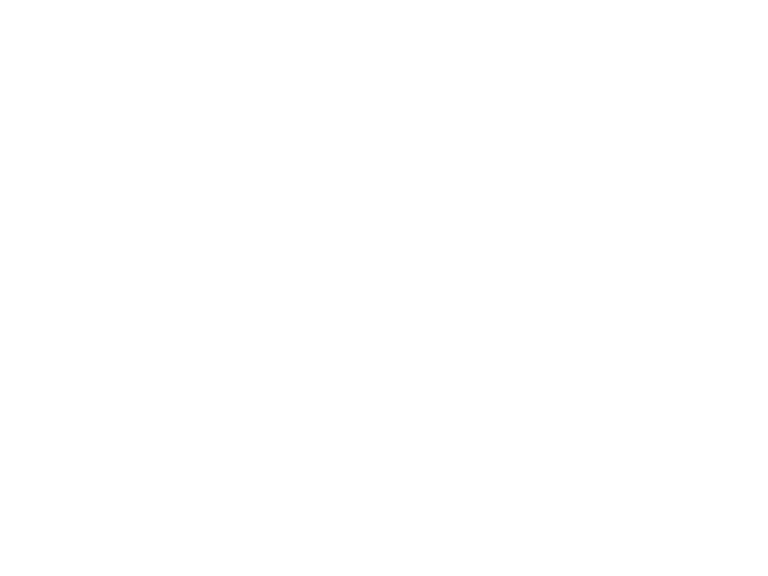

In [78]:
for bidx, full in enumerate(walks):
#     for dim, (frames, nums) in enumerate(zip(full, deltas[bidx].T)):
#         a = util.Animation(get_traversal_anim(frames, vals=nums, scale=16, fps=10))
#         break
#     break
    a = util.Animation(get_traversal_anim(tile_dims(full), vals=None, scale=16, fps=10))
    break

In [79]:
a.play()

In [2]:
A = trn.get_config('branchdec')
A.din = 3,64,64
A.latent_dim = 12
A.dout = 3,64,64

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [3]:
A.pull('model.decoder')

Creating decoder (type=branch-dec)
  latent_dim: 12 (in parent)
  out_shape --> dout: (3, 64, 64) (in parent)
  root_dim: 0
  branch_dim: 3
    channels (type=list): 
    [0]: 128
    [1]: 128
    [2]: 64
    [3]: 64
  factors: 2
  branches (type=iter) with 4 elements
  layers (type=iter) with 4 elements
  Creating branches[0] (type=norm-ada-in)
    style_dim --> din: 3
    features --> dout: 128
    pixelwise: False (by default)
    Creating net (type=mlp) (mod=normal) (in parent)
      latent_dim: 12 (in parent)
      min_log_std: None (by default)
      input_dim --> din: 3
      output_dim --> dout: 24
        hidden_dims (type=list): 
        [0]: 64
        [1]: 128
      nonlin: prelu (by default)
      output_nonlin: None (by default)
  Creating layers[0] (type=deconv-layer)
    in_channels: 128
    out_channels: 128
    factor: 2
    kernel_size: 3 (by default)
    stride: 1 (by default)
    padding: None (by default)
    dilation: 1 (by default)
    output_padding: 0 (by defa

AttributeError: 'Deconv_Layer' object has no attribute 'up_type'

In [8]:
A = trn.get_config()
A.model._type = 'dislib-dec'
A.model.dout = (3,128,128)
A.model.din = 10

In [9]:
model = A.pull('model')

Creating model (type=dislib-dec)
  latent_dim --> din: 10
  out_shape --> dout: (3, 128, 128)
  nonlin: relu (by default)
  net_type: conv (by default)


In [10]:
print(model)

Disentanglement_lib_Decoder(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): Reshaper(out=(64, 4, 4))
  )
  (deconv): Sequential(
    (0): DeconvLayer(
      (deconv): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (nonlin): ReLU(inplace=True)
    )
    (1): DeconvLayer(
      (deconv): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (nonlin): ReLU(inplace=True)
    )
    (2): DeconvLayer(
      (deconv): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (nonlin): ReLU(inplace=True)
    )
    (3): DeconvLayer(
      (deconv): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (nonlin): ReLU(inplace=True)
    )
    (4): DeconvLayer(
      (deconv): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (n

In [19]:
x = torch.randn(3,3)

In [22]:
x

tensor([[ 0.5952,  0.4880,  0.2048],
        [-0.3997, -0.3645, -0.6762],
        [ 0.9419, -1.9665, -1.9220]])

In [24]:
x.norm(p=float('inf'), dim=None)

tensor(1.9665)

In [13]:
util.count_parameters(model)

398755

In [11]:
q = torch.randn(64,10)

In [12]:
with torch.no_grad():
    rec = model(q)
rec.shape

torch.Size([64, 3, 128, 128])

In [5]:
dataset = trn.get_dataset('3dshapes', labeled=False)
len(dataset)

Loading dataset: 3dshapes
dataroot: /is/ei/fleeb/workspace/local_data/
load_memory: True (by default)
train: True (by default)
labeled: False
noise: None (by default)
din: (3, 64, 64) (by default)
dout: (3, 64, 64) (by default)


384000

In [6]:
dataloader = trn.get_loaders(dataset, batch_size=64, drop_last=False)
len(dataloader)

Using batched data loader


6000

In [7]:
for batch in dataloader:
    pass

In [8]:
X = batch[0]
X.shape

torch.Size([64, 3, 64, 64])

In [11]:
q = model(X)
q.loc.shape, q.stddev.shape

(torch.Size([64, 10]), torch.Size([64, 10]))

In [13]:
shapes, settings = models.plan_conv((3,64,64), channels=[32,32,64,64], kernels=[4,4,2,2], strides=[2,2,2,2])

In [16]:
print(shapes)

[(3, 128, 128), (32, 64, 64), (32, 32, 32), (64, 16, 16), (64, 8, 8), (64, 4, 4)]


In [14]:
print(models.build_conv_layers(settings))

[ConvLayer(
  (conv): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nonlin): ELU(alpha=1.0, inplace=True)
), ConvLayer(
  (conv): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nonlin): ELU(alpha=1.0, inplace=True)
), ConvLayer(
  (conv): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nonlin): ELU(alpha=1.0, inplace=True)
), ConvLayer(
  (conv): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nonlin): ELU(alpha=1.0, inplace=True)
), ConvLayer(
  (conv): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
)]


In [2]:
shapes, settings = models.plan_deconv((3,64,64), channels=[64,64,32,32], kernels=[2,2,4,4,], strides=[2,2,2,2])
print(shapes)

[(64, 4, 4), (64, 8, 8), (32, 16, 16), (32, 32, 32), (3, 64, 64)]


In [4]:
dec = models.build_deconv_layers(settings, shapes[:-1])
print(dec)

[DeconvLayer(
  (deconv): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nonlin): ELU(alpha=1.0, inplace=True)
), DeconvLayer(
  (deconv): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nonlin): ELU(alpha=1.0, inplace=True)
), DeconvLayer(
  (deconv): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nonlin): ELU(alpha=1.0, inplace=True)
), DeconvLayer(
  (deconv): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)]


In [2]:
class T(object):
    def __repr__(self):
        return 'a\nb\nc'

In [3]:
data = {'a':2, 'wow':T(), 'b':{'x':[1,2,3], 'y':{'t1': {'a','b','sdg'}, 't2':5}}}

In [4]:
print(util.pretty_format(data))

{
  'a': 2
  'wow': a
      b
      c
  'b': {
    'x': [
      1
      2
      3
    ]
    'y': {
      't1': {
        'a'
        'b'
        'sdg'
      }
      't2': 5
    }
  }
}


In [2]:
%matplotlib notebook

In [3]:
# raw, labels = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
# labels = labels.astype(int)

In [4]:
# data = raw.reshape(-1,28,28)[:10000, ::2, ::2]
# _,H, W = data.shape
# data = data.reshape(len(data),-1)
# # data = data.astype('float32')
# lbls = labels[:10000]
# data.shape, lbls.shape

In [5]:
# start = time.time()
# mapper = umap.UMAP(random_state=1).fit(data)
# print('took {:.2f}'.format(time.time() - start))

In [6]:
# Q = mapper.embedding_
# Q.shape

In [7]:
# vals = set(lbls)
# num = len(vals)
# vals = sorted(list(vals))
# num, vals

In [8]:
# cmap = matplotlib.cm.get_cmap('Spectral')
# cmap

In [9]:
# plt.figure(figsize=(8,8))
# plt.scatter(*Q.T, c=lbls, cmap=cmap, marker='.', s=10)

# hdls = []
# for i in np.arange(num):
#     l = i/(num-1)
#     v = vals[i]
#     hdls.append( mpatches.Patch(color=cmap(l), label=str(v)))
# plt.legend(handles=hdls)
# pass

In [10]:
# Q.shape

In [11]:
# gen = Q[:16]
# # gen = np.random.randn(16,2)*10
# gen.shape

In [12]:
# rec = mapper.inverse_transform(gen)
# rec.shape

In [13]:
# util.show_nums(torch.from_numpy(rec.reshape(-1,1,H,W)))
# pass

In [28]:
N,C,H,W = 5, 3, 10,10

[autoreload of foundation.data.collectors failed: Traceback (most recent call last):
  File "/is/ei/fleeb/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/is/ei/fleeb/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/is/ei/fleeb/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/is/ei/fleeb/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/is/ei/fleeb/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 312, in update_instances
    update_instances(old, new, obj.__dict__, visited)
  File "/is/ei/fleeb/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    updat

In [35]:
X = torch.arange(N*C*H*W).view(N,C,H,W).float()
X.shape

torch.Size([5, 3, 10, 10])

In [38]:
unf = nn.Unfold((2,2), padding=1)

In [39]:
unf(X).shape

torch.Size([5, 27, 100])

In [4]:
dataset = trn.get_dataset('3dshapes', labeled=True)
len(dataset)

Loading dataset: 3dshapes
dataroot: /is/ei/fleeb/workspace/local_data/
load_memory: True (by default)
train: True (by default)
labeled: True
noise: None (by default)
din: (3, 64, 64) (by default)
dout: 6 (by default)


384000

In [5]:
dataset.images.shape

torch.Size([384000, 3, 64, 64])

In [6]:
# X = dataset.images.view(-1, 28*28)
torch.manual_seed(0)
order = torch.randperm(len(dataset))
# order = slice(None)
X = dataset.images[order]#,:,::2,::2]
print(X.shape)
_, C, H, W = X.shape
X = X.contiguous().view(len(dataset),-1)#.div(255)
if X.dtype == torch.uint8:
    X = X.float().div(255)
X = X.float()
Y = dataset.labels[order]
X.shape, Y.shape

torch.Size([384000, 3, 64, 64])


(torch.Size([384000, 12288]), torch.Size([384000, 6]))

In [23]:
N = 30000

trainX, trainY = X[:N], Y[:N]
trainX.shape, trainY.shape
# trainY[:16]

(torch.Size([30000, 12288]), torch.Size([30000, 6]))

In [24]:
R = gpumap.GPUMAP(n_components=64, random_state=1)#, min_dist=0.8, n_neighbors=100)#target_metric='haversine')
R

GPUMAP(a=None, angular_rp_forest=False, b=None, init='default',
       learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
       metric_kwds=None, min_dist=0.1, n_components=64, n_epochs=None,
       n_neighbors=15, negative_sample_rate=5, random_state=1,
       repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
       target_metric='categorical', target_metric_kwds=None,
       target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
       transform_seed=42, use_gpu=True, verbose=False)

In [25]:
# R = umap.UMAP()
# R = umap.UMAP(n_components=12)
# R

In [26]:
start = time.time()
R.fit(trainX.numpy())
print('took {:.2f}'.format(time.time() - start))


Compilation is falling back to object mode WITH looplifting enabled because Function "make_epochs_per_sample" failed type inference due to: Untyped global name 'make_epochs_per_sample_gpu': cannot determine Numba type of <class 'function'>

File "../gpumap/gpumap/gpumap_.py", line 816:
def make_epochs_per_sample(weights, n_epochs, use_gpu):
    <source elided>
	if use_gpu:
		fun = make_epochs_per_sample_gpu
  ^

Function "make_epochs_per_sample" was compiled in object mode without forceobj=True.

File "../gpumap/gpumap/gpumap_.py", line 799:
@numba.jit()
def make_epochs_per_sample(weights, n_epochs, use_gpu):
^


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "../gpumap/gpumap/gpumap_.py", line 799:
@numba.jit()
def make_epochs_per_sample(wei

took 37.27


In [10]:
# start = time.time()
# Q = torch.from_numpy(R.transform(trainX))
ref = torch.from_numpy(R.embedding_)
# print('took {:.2f}'.format(time.time() - start))
# ref = Q
ref.shape

torch.Size([10000, 64])

In [38]:
# np.save('temp.npy', ref.numpy())

In [39]:
ref = np.load('temp.npy')
ref = torch.from_numpy(ref)

In [12]:
Q = ref
Q.shape

torch.Size([10000, 64])

In [54]:
# V = gpumap.GPUMAP()#min_dist=0.8, n_neighbors=100)
V = umap.UMAP(random_state=1)#min_dist=0.8, n_neighbors=20)
# V = PCA(n_components=2)
V

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=1, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

In [55]:
start = time.time()
V.fit(Q.numpy())
print('took {:.2f}'.format(time.time() - start))

Embedding a total of 33 separate connected components using meta-embedding (experimental)


took 14.60


In [56]:
B = 10000

if isinstance(V, PCA):
    points = V.transform(Q[:B].numpy())
else:
    points = V.embedding_[:B]
    
# points = V.transform(Q[:B].numpy())
# points = ref.numpy()
    
# points = R.embedding_[:B]

# lb = trainY[:B].clone()

points = torch.from_numpy(points)
points.shape

torch.Size([10000, 2])

In [57]:
cmap = matplotlib.cm.get_cmap('Spectral')
cmap

<IPython.core.display.Javascript object>


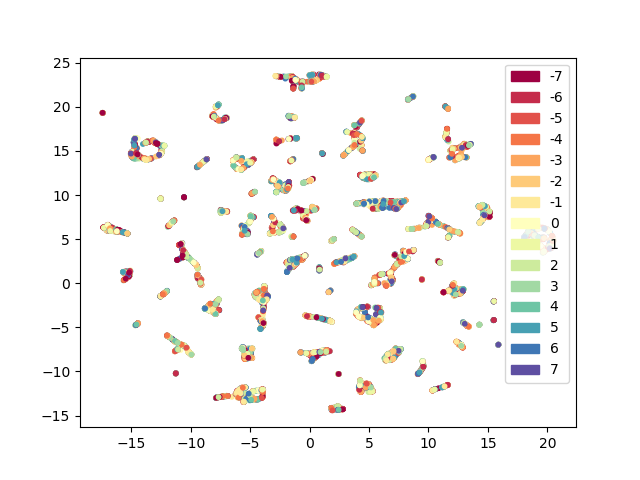

In [64]:

# lb = trainY[:B].clone()
lb = trainY[:B,5].clone()
vals = np.array(sorted(set(lb.numpy())))
num = len(vals)
lb /= vals[1] - vals[0]
vals /= vals[1] - vals[0]
lb = lb.round().int()
vals = vals.round().astype('int')

fig, ax = plt.subplots()
plt.scatter(*points.numpy().T, cmap=cmap, c=lb, marker='o', s=10)

hdls = []
for i in np.arange(num):
    l = i/(num-1)
    hdls.append( mpatches.Patch(color=cmap(l), label=str(int(vals[i]))))
plt.legend(handles=hdls)
pass

In [30]:
# umap.plot.points(R, labels=Y[:10000], theme='fire')

In [15]:
# latent = torch.randn(16, 2)
latent = Q[:1]
# vlat = points[:16]
# latent = F.normalize(latent, dim=-1)
vlat = latent
vlat.shape

torch.Size([1, 64])

In [66]:
# gen = V.inverse_transform(vlat)
# gen = torch.from_numpy(gen)
# gen.shape

In [33]:
# util.show_nums(gen.view(-1, C, H, W))
# pass

<IPython.core.display.Javascript object>


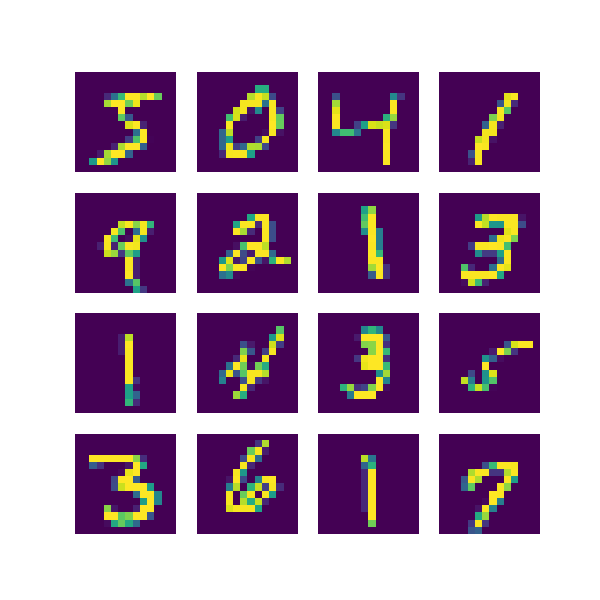

In [35]:
util.show_nums(trainX[:16].view(-1,C,H,W))
pass

In [16]:
R.__class__.inverse_transform = umap.UMAP.inverse_transform
R.output_metric = 'euclidean'
R._output_metric_kwds = {}

In [ ]:
gen = R.inverse_transform(vlat)
gen = torch.from_numpy(gen)
gen.shape

In [45]:
reqs = ['_sparse_data', 'metric', 'transform_seed', 'embedding_', '_raw_data', 'output_metric', '_output_metric_kwds', '_a', '_b', 'n_epochs','_sigmas', '_rhos', 'repulsion_strength', '_initial_alpha', 'negative_sample_rate', 'verbose']
reqs = set(reqs)

In [46]:
for r in reqs:
    a = getattr(V,r)
    b = getattr(R,r)
    if isinstance(a, np.ndarray):
        print(r, a.shape, a.dtype, b.shape, b.dtype)
    else:
        print(r, a, b)

_raw_data (10000, 196) float32 (10000, 196) float32
metric euclidean euclidean
_rhos (10000,) float32 (10000,) float32
verbose False False
repulsion_strength 1.0 1.0
embedding_ (10000, 2) float32 (10000, 2) float32
transform_seed 42 42
_a 1.576943460405378 1.576943460405378
_b 0.8950608781227859 0.8950608781227859
_initial_alpha 1.0 1.0
negative_sample_rate 5 5
_output_metric_kwds {} {}
_sigmas (10000,) float32 (10000,) float32
n_epochs None None
output_metric euclidean euclidean
_sparse_data False False


In [16]:
# langl = util.cart2angl(latent)

# langl = angles[:16]
# langl[8:] = util.cart2angl(util.angl2cart(angles[:8]))
# langl

# latent = points[:16]
# latent.shape

In [33]:
# plt.sca(ax)
# # plt.scatter(*latent.numpy().T, c='k', marker='x', s=100)
# for i,(x,y) in enumerate(vlat.numpy()):
#     plt.text(x.item(),y.item(), s=str(i), fontsize=12, horizontalalignment='center', verticalalignment='center', )

In [68]:
# gen = R.inverse_transform(latent.numpy())
# gen = torch.from_numpy(gen).view(-1, 1, 28, 28)
# gen.shape

In [2]:
C = trn.get_config()
C

{{'_ipython_canary_method_should_not_exist_':{{}}}}

In [3]:
C.criterion._type = 'criterion'
C.criterion.name = 'bce'
C.criterion.kwargs.reduction = 'sum'
C

{{'_ipython_canary_method_should_not_exist_':{{}}, 'criterion':{{'_type':'criterion', 'name':'bce', 'kwargs':{{'reduction':'sum'}}}}}}

In [4]:
criterion = C.pull('criterion')

Creating criterion (type=criterion)
  name: bce
    kwargs (type=dict): 
    (reduction): sum


In [6]:
criterion.reduction

'sum'

In [7]:
import inspect

In [ ]:
util.show_nums(gen.view(-1, C, H, W))
pass

In [44]:
for n, p in sig.parameters.items():
    print(n, p.default, p.kind)
#     break

a <class 'inspect._empty'> POSITIONAL_OR_KEYWORD
b <class 'inspect._empty'> POSITIONAL_OR_KEYWORD
c 1 POSITIONAL_OR_KEYWORD
d [1, 2, 3] POSITIONAL_OR_KEYWORD
e 13 POSITIONAL_OR_KEYWORD
kwargs <class 'inspect._empty'> VAR_KEYWORD


In [35]:
p.POSITIONAL_OR_KEYWORD

<_ParameterKind.POSITIONAL_OR_KEYWORD: 1>

In [22]:
p.kind

<_ParameterKind.VAR_KEYWORD: 4>

In [17]:
p.default == inspect._empty

True

In [29]:
type(p.kind)

<enum '_ParameterKind'>

In [34]:
{inspect._ParameterKind.VAR_POSITIONAL, inspect._ParameterKind.VAR_KEYWORD} == p.kind

True

In [36]:
p.default

inspect._empty